<a href="https://colab.research.google.com/github/ravi-gopalan/DAND_Data_Wrangling/blob/master/fastai_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
from fastai import *
from fastai.vision import *

import os
import time

In [0]:
image_dir = '/gdrive/My Drive/yelp_dataset/y_photos'
predict_dir = '/gdrive/My Drive/yelp_dataset/testing_pics'

In [5]:
print('Train: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/train/approved')), len(os.listdir(image_dir+'/train/ineligible'))))
print('Valid: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/valid/approved')), len(os.listdir(image_dir+'/valid/ineligible'))))
print('Test: Approved {}, Ineligible {}'.format(len(os.listdir(image_dir+'/test/approved')), len(os.listdir(image_dir+'/test/ineligible'))))

Train: Approved 863, Ineligible 341
Valid: Approved 291, Ineligible 110
Test: Approved 288, Ineligible 113


# Create Databunch

In [6]:
data = (ImageList.from_folder(image_dir)
        .split_by_folder()          
        .label_from_folder()
        .transform(get_transforms(do_flip=False), size=224)
        .databunch(bs=32)
        .normalize(imagenet_stats))

len(data.classes)

2

# Create a Learner

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:05<00:00, 16.1MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


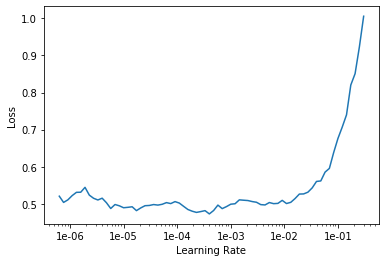

In [7]:
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy, Recall(average='macro'), Precision(average='macro'),FBeta(average='macro')])

learn_resnet34.fit_one_cycle(2)
learn_resnet34.save('stage_1_resnet34')
# Find out learning rate
learn_resnet34.lr_find()
# Plot learning rate
learn_resnet34.recorder.plot()



In [8]:
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(20, max_lr = slice(1e-6,1e-4))

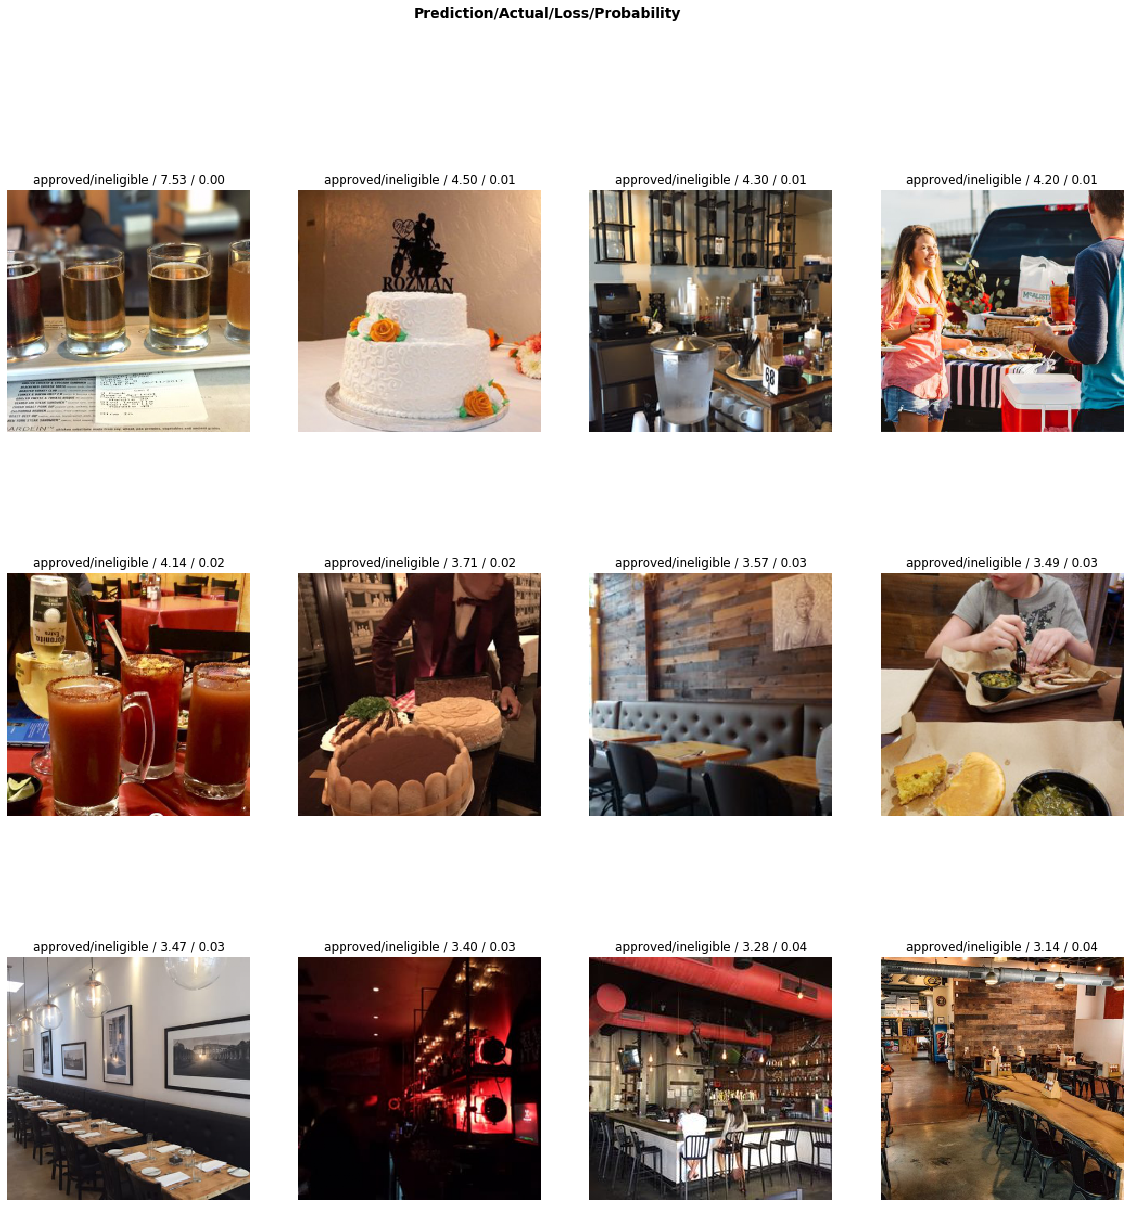

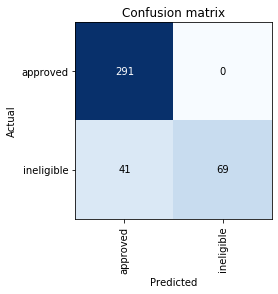

In [9]:
interp_resnet34 = ClassificationInterpretation.from_learner(learn_resnet34)
interp_resnet34.plot_top_losses(12, figsize=(20,20))

interp_resnet34.plot_confusion_matrix()

In [10]:
os.listdir(predict_dir)

['FINAL+Grand+Menu+Final+WS-2.jpg',
 'AnnoyingDiners1.jpg',
 'lnm8ug2hsay4c4nf3zbd.jpg',
 '5050.jpg',
 'cj2rvsmnwqmvfrfznkly.jpg',
 'w7ms8f6xqmqwdzvtoq8x.jpg']

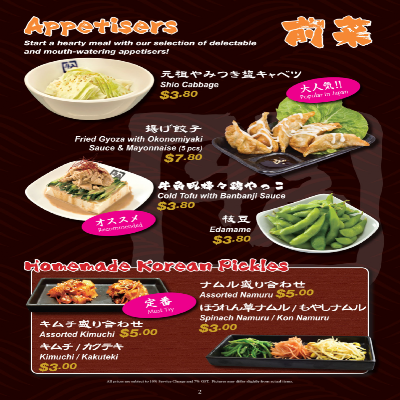

81.05% probability of review being approved 



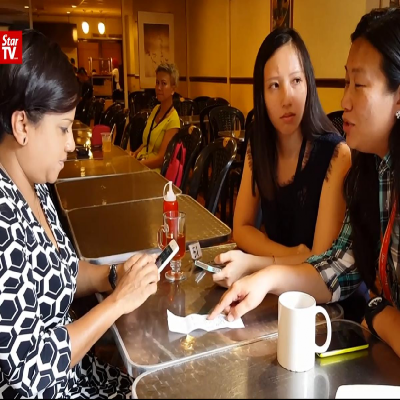

95.64% probability of review being ineligible 



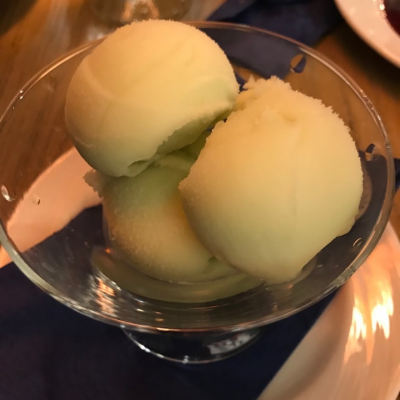

99.87% probability of review being approved 



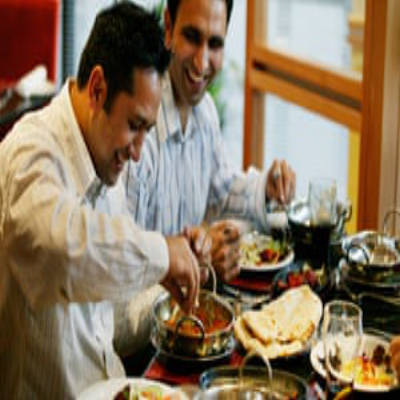

61.14% probability of review being approved 



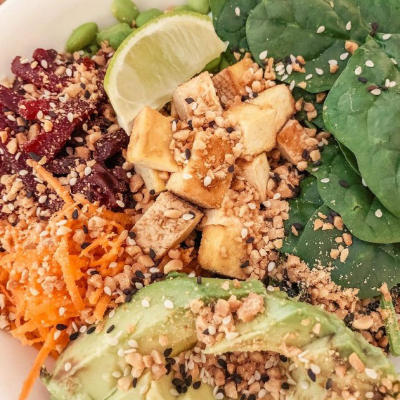

99.69% probability of review being approved 



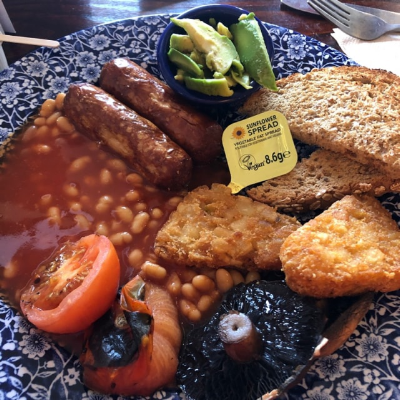

98.44% probability of review being approved 



In [14]:

for pic in os.listdir(predict_dir):
  file_path = str(predict_dir+'/'+pic)
  open_image(file_path).resize(400)
  predicted_status, tensor_index, probability_tensor = learn_resnet34.predict(open_image(file_path).resize(200))
  prob = max(probability_tensor[0].item(),probability_tensor[1].item())
  print('{:.2f}% probability of review being {} \n'.format(100*prob, predicted_status.obj))
  time.sleep(5)